# neptune setup
* export NEPTUNE_API_TOKEN="..."

In [1]:
import neptune.new as neptune

# 새로 실험 아이디 얻고 싶을때
#run = neptune.init(project='hakmink/pycaret', tags=['regression','interpretml'], api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMjRiNGE3MS0wYmFlLTQyMjktODhkNy0wZTNmNmM4NmE0ZWUifQ==')
#run = neptune.init(project='hakmink/pycaret', tags=['regression','interpretml'])

# rerun
#run = neptune.init(project='hakmink/pycaret', run='PYCAR-13', tags=['regression','interpretml'])

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/hakmink/pycaret/e/PYCAR-13


## default fields setup
* inspired by pycaret mlflow ui

In [3]:
run['run name'] = 'base model' # your exp name
run['source'] = 'jupyter'
run['version'] = ''


run['mae'] = 0.0
run['mse'] = 0.0
run['rmse'] = 0.0
run['r2'] = 0.0
run['rmsle'] = 0.0
run['mape'] = 0.0
run['algorithm'] = ''

# library & data load

In [4]:
from os import path
import pandas as pd
import numpy as np
import reducing
import pickle


np.random.seed(0)
df_pickle = '../data/wine_data/original_df.pickle'
wine_file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
if path.exists(df_pickle):
    with open(df_pickle, 'rb') as handle:
        df = pickle.load(handle)
else:
    df = reducing.import_data(wine_file, delimiter=';')
    #for later use, save df as pickle
    with open(df_pickle, 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       7.398438          0.700195     0.000000        1.900391   0.075989   
1       7.800781          0.879883     0.000000        2.599609   0.098022   
2       7.800781          0.759766     0.040009        2.300781   0.091980   
3      11.203125          0.280029     0.560059        1.900391   0.075012   
4       7.398438          0.700195     0.000000        1.900391   0.075989   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0                 11.0                  34.0  0.997559  3.509766   0.560059   
1                 25.0                  67.0  0.996582  3.199219   0.680176   
2                 15.0                  54.0  0.997070  3.259766   0.649902   
3                 17.0                  60.0  0.998047  3.160156   0.580078   
4                 11.0                  34.0  0.997559  3.509766   0.560059   

    alcohol  quality  
0  9.398438        5  
1  9.796875        5  
2  9.796875        5  
3  9.796875        6  
4  9.398438        5

In [6]:
df.dtypes

fixed acidity           float16
volatile acidity        float16
citric acid             float16
residual sugar          float16
chlorides               float16
free sulfur dioxide     float16
total sulfur dioxide    float16
density                 float16
pH                      float16
sulphates               float16
alcohol                 float16
quality                    int8
dtype: object

## Sample data - neptune upload

In [7]:
from util import write_to_html_file
from neptune.new.types import File


write_to_html_file(df.head(), title='Sample - Wine Data', filename='sample_data.html')

run['data/sample'].upload('sample_data.html')

In [8]:
isna_info = df.isna().describe()

write_to_html_file(isna_info, title='Describe Data - isna', filename='isna.html')

run['data/isna'].upload('isna.html')

## Profiling report - neptune upload
* https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/pages/advanced_usage.html

In [19]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df.sample(frac=0.1), 
                        explorative=True,
                        correlations={
                            "pearson": {"calculate": False},
                            "spearman": {"calculate": False},
                            "kendall": {"calculate": False},
                            "phi_k": {"calculate": False},
                            "cramers": {"calculate": False},
                        },
)


#Saving results to a HTML file
profile.to_file("profile_data.html")

run['data/profile'].upload('profile_data.html')

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

/Users/a405305/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/a405305/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Machine Learning Setup

## pycaret 2.2 what is new
* https://towardsdatascience.com/pycaret-2-2-is-here-whats-new-ad7612ca63b
* gpu enabled
* refactored to improve memory footprint and optimize performance
> 5M sampled rows from the famous New York Taxi Dataset (AMD64 machine with 8 CPU cores)
-> 9min 23s (v2.1) VS 39.9s (v2.2) 
* add_metric
```
# add Log Loss metric in pycaret
from sklearn.metrics import log_loss
add_metric(id='logloss', 
           name='LogLoss', 
           score_func=log_loss, 
           target='pred_proba',
           greater_is_better=False)
```
* skip preprocessing
```
# initializing setup
from pycaret.classification import *
clf = setup(data = train_data, preprocess = False) 
```
* separate train and test set
```
# loading dataset
import pandas as pd
train_data = pd.read_csv('/path/train.csv')
test_data = pd.read_csv('/path/test.csv')
# initializing setup
from pycaret.classification import *
clf = setup(data = train_data, test_data = test_data)
```

In [19]:
from pycaret.regression import *
reg1 = setup(df, target = 'quality', 
             session_id=123, 
             train_size=0.8,
             fold=2,
             log_experiment=True, 
             feature_interaction=True,
             feature_ratio=True,
             #polynomial_features=True,
             trigonometry_features=True,
             group_features=['fixed acidity','volatile acidity','citric acid','free sulfur dioxide','total sulfur dioxide'],
             bin_numeric_features=['citric acid'],
             experiment_name='wine2')

## get config

In [20]:
get_config('X').dtypes

fixed acidity                          float16
volatile acidity                       float16
residual sugar                         float16
chlorides                              float16
free sulfur dioxide                    float16
total sulfur dioxide                   float16
density                                float16
pH                                     float16
sulphates                              float16
alcohol                                float16
group_0_Min                            float64
group_0_Mean                           float64
group_0_Median                         float64
group_0_Mode                           float16
citric acid_0.0                        float32
citric acid_1.0                        float32
citric acid_10.0                       float32
citric acid_11.0                       float32
citric acid_2.0                        float32
citric acid_3.0                        float32
citric acid_4.0                        float32
citric acid_5

In [21]:
get_config('X').head()

fixed acidity  volatile acidity  residual sugar  chlorides  \
0       7.398438          0.700195        1.900391   0.075989   
1       7.800781          0.879883        2.599609   0.098022   
2       7.800781          0.759766        2.300781   0.091980   
3      11.203125          0.280029        1.900391   0.075012   
4       7.398438          0.700195        1.900391   0.075989   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0                 11.0                  34.0  0.997559  3.509766   0.560059   
1                 25.0                  67.0  0.996582  3.199219   0.680176   
2                 15.0                  54.0  0.997070  3.259766   0.649902   
3                 17.0                  60.0  0.998047  3.160156   0.580078   
4                 11.0                  34.0  0.997559  3.509766   0.560059   

    alcohol  ...  pH_multiply_density  density_multiply_alcohol  \
0  9.398438  ...             3.501953                  9.375000   
1  9.796875  ...             3.187500                  9.765625   
2  9.796875  ...             3.250000                  9.765625   
3  9.796875  ...             3.154297                  9.781250   
4  9.398438  ...             3.501953                  9.375000   

   pH_divide_volatile acidity  chlorides_multiply_fixed acidity  \
0                    5.011719                          0.562012   
1                    3.636719                          0.764648   
2                    4.289062                          0.717285   
3                   11.281250                          0.840332   
4                    5.011719                          0.562012   

   pH_multiply_chlorides  sulphates_multiply_chlorides  \
0               0.266602                      0.042572   
1               0.313477                      0.066650   
2               0.299805                      0.059784   
3               0.237061                      0.043518   
4               0.266602                      0.042572   

   volatile acidity_divide_alcohol  group_0_Median_multiply_sulphates  \
0                         0.074524                           4.143559   
1                         0.089783                           5.305902   
2                         0.077576                           5.069746   
3                         0.028580                           6.498688   
4                         0.074524                           4.143559   

   pH_multiply_alcohol  density_multiply_sulphates  
0            33.000000                    0.558594  
1            31.343750                    0.677734  
2            31.937500                    0.647949  
3            30.953125                    0.579102  
4            33.000000                    0.558594  

[5 rows x 40 columns]

In [22]:
get_config('y').head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int8

## Setup reporting

In [23]:
setup_info = get_config('display_container')[-1].render()
with open('setup_info.html', 'w') as f:
    f.write(setup_info)
run['model/setup_info'].upload('setup_info.html')

## Compare Models

In [24]:
best_model = compare_models(include = ['rf','xgboost','catboost','en'], sort='RMSE')
best_model

In [25]:
best_model_result = pull()
display(best_model_result)
# same
best_model_result = get_config('display_container')[-1]
display(best_model_result)

Model     MAE     MSE    RMSE      R2   RMSLE  \
catboost         CatBoost Regressor  0.4446  0.3735  0.6103  0.4234  0.0942   
rf          Random Forest Regressor  0.4546  0.3790  0.6154  0.4136  0.0953   
xgboost   Extreme Gradient Boosting  0.4509  0.4222  0.6498  0.3459  0.1009   
en                      Elastic Net  0.5827  0.5339  0.7306  0.1733  0.1124   

            MAPE  TT (Sec)  
catboost  0.0815     3.145  
rf        0.0836     2.585  
xgboost   0.0826     1.580  
en        0.1073     0.025

Model     MAE     MSE    RMSE      R2   RMSLE  \
catboost         CatBoost Regressor  0.4446  0.3735  0.6103  0.4234  0.0942   
rf          Random Forest Regressor  0.4546  0.3790  0.6154  0.4136  0.0953   
xgboost   Extreme Gradient Boosting  0.4509  0.4222  0.6498  0.3459  0.1009   
en                      Elastic Net  0.5827  0.5339  0.7306  0.1733  0.1124   

            MAPE  TT (Sec)  
catboost  0.0815     3.145  
rf        0.0836     2.585  
xgboost   0.0826     1.580  
en        0.1073     0.025

In [26]:
run["model/best_model"] = best_model

write_to_html_file(get_config('display_container')[-1], title='Best Model', filename='best_model_result.html')
run['model/best_model_comparison'].upload('best_model_result.html')

## Create Model - catboost

In [27]:
catboost = create_model('catboost')

In [28]:
model_name = 'catboost'
title = '{model_name} - before hyperparameter tuning'.format(model_name=model_name)
filename = '{model_name}_before_tuned'.format(model_name=model_name)

write_to_html_file(get_config('display_container')[-1], 
                   title=title, 
                   filename=filename+'.html')
run['model/'+filename].upload(filename+'.html')
run['model/'+model_name] = catboost

## Hyperparameter Tunning

In [29]:
tuned_catboost = tune_model(catboost, search_library='scikit-optimize', search_algorithm='bayesian', optimize='RMSE')

In [44]:
tuned_catboost = tune_model(catboost)

In [30]:
model_name = 'catboost'
title = '{model_name} - after hyperparameter tuning'.format(model_name=model_name)
filename = '{model_name}_after_tuned'.format(model_name=model_name)

write_to_html_file(get_config('display_container')[-1], 
                   title=title, 
                   filename=filename+'.html')
run['model/'+filename].upload(filename+'.html')
run['model/'+model_name] = tuned_catboost


In [31]:
mae = get_config('display_container')[-1]['MAE']['Mean']
mse = get_config('display_container')[-1]['MSE']['Mean']
rmse = get_config('display_container')[-1]['RMSE']['Mean']
r2 = get_config('display_container')[-1]['R2']['Mean']
rmsle = get_config('display_container')[-1]['RMSLE']['Mean']
mape = get_config('display_container')[-1]['MAPE']['Mean']

run['mae'] = mae
run['mse'] = mse
run['rmse'] = rmse
run['r2'] = r2
run['rmsle'] = rmsle
run['mape'] = mape
run['algorithm'] = 'tuned_catboost'

# Interpret Model

## Plot Model

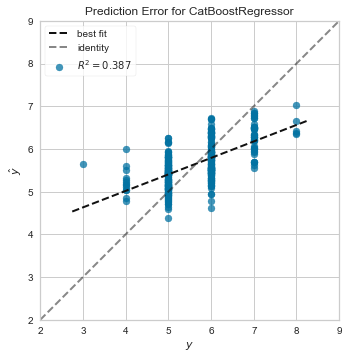

In [32]:
plot_model(tuned_catboost, 'error')

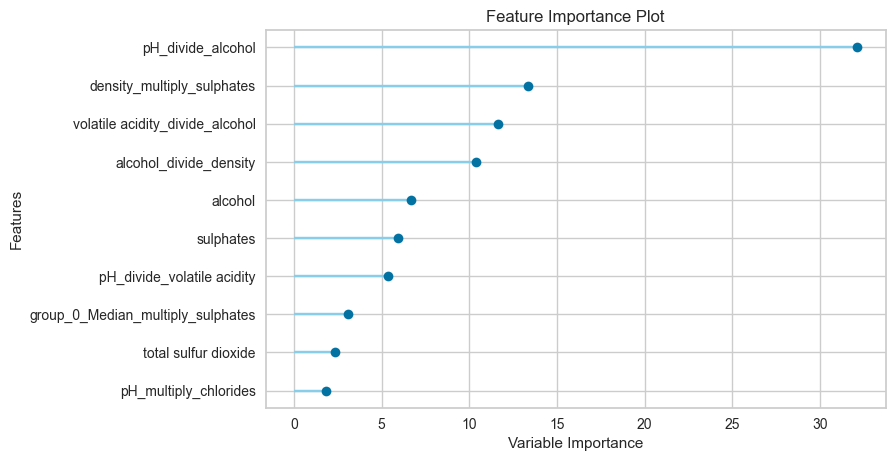

In [33]:
plot_model(tuned_catboost, 'feature')

In [34]:
plot_model(tuned_catboost, 'parameter')

Parameters
nan_mode                                           Min
eval_metric                                       RMSE
iterations                                         222
sampling_frequency                             PerTree
leaf_estimation_method                          Newton
grow_policy                              SymmetricTree
penalties_coefficient                                1
boosting_type                                    Plain
model_shrink_mode                             Constant
feature_border_type                       GreedyLogSum
bayesian_matrix_reg                0.10000000149011612
l2_leaf_reg                                         72
random_strength                     0.5579679608345032
rsm                                                  1
boost_from_average                                True
model_size_reg                                     0.5
pool_metainfo_options                     {'tags': {}}
subsample                            0.800000011920929
use_best_model                                   False
random_seed                                        123
depth                                                1
posterior_sampling                               False
border_count                                       254
classes_count                                        0
auto_class_weights                                None
sparse_features_conflict_fraction                    0
leaf_estimation_backtracking            AnyImprovement
best_model_min_trees                                 1
model_shrink_rate                                    0
min_data_in_leaf                                     1
loss_function                                     RMSE
learning_rate                       0.4390767514705658
score_function                                  Cosine
task_type                                          CPU
leaf_estimation_iterations                           1
bootstrap_type                                     MVS
max_leaves                                           2

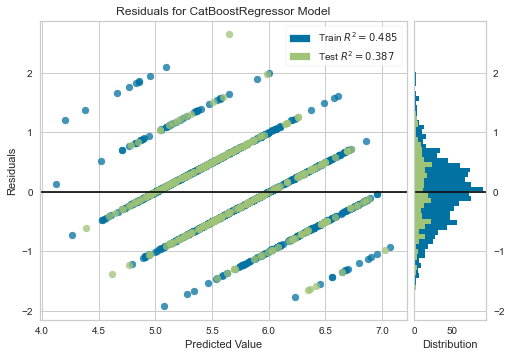

In [35]:
plot_model(tuned_catboost, 'residuals')

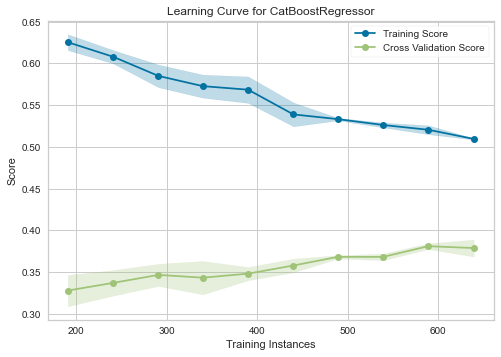

In [36]:
plot_model(tuned_catboost, 'learning')

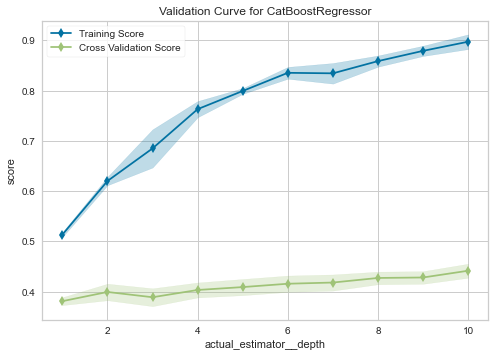

In [37]:
plot_model(tuned_catboost, 'vc')

## Summary

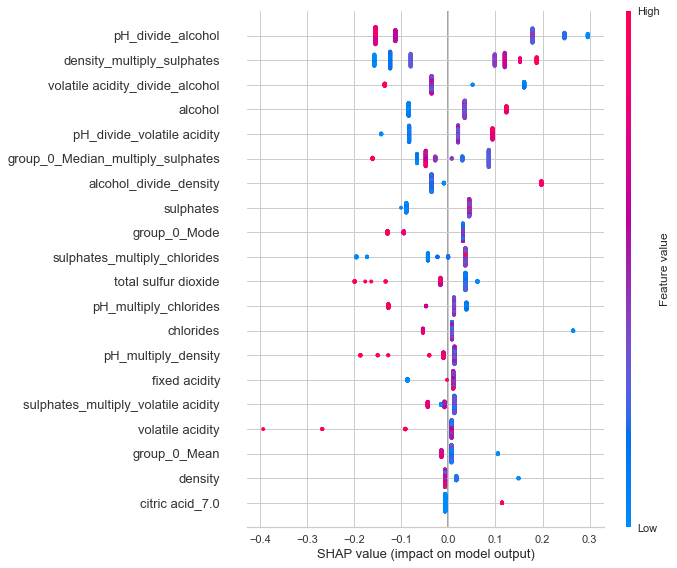

In [38]:
interpret_model(tuned_catboost)

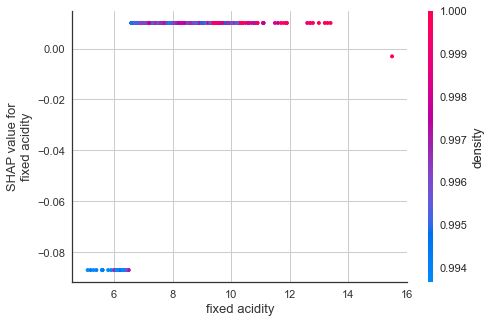

In [39]:
interpret_model(tuned_catboost, plot = 'correlation')

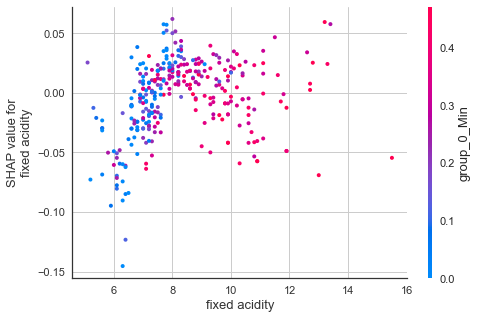

In [45]:
interpret_model(tuned_catboost, plot = 'correlation')

In [40]:
interpret_model(tuned_catboost, plot = 'reason', observation = 10)

In [43]:
df.iloc[10]['quality']

5.0

In [ ]:
!mlflow ui